In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
class GPR():
    def __init__(self, kernel, alpha=1e-10, n_restarts_optimizer=20):
        self.gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=n_restarts_optimizer)

    def fit(self, X, Y):
        self.X=X
        self.Y=Y
        self.n_features=np.shape(self.X)[1]
        self.n_samples=np.shape(self.X)[0]
        self.n_outputs=np.shape(self.Y)[1]
        gp_ = self.gp.fit(self.X, self.Y)

        self.kernel_ = gp_.kernel_

        self.length_scales=self.kernel_.get_params()['k1__k2__length_scale'].reshape(1,-1)
        
        print("Lengthscale", self.length_scales)
        
        self.noise_var_ = gp_.alpha + self.kernel_.get_params()['k2__noise_level']

        print("Noise variance", self.noise_var_)

        self.Sigma_v   = self.kernel_.get_params()['k1__k1__constant_value'].reshape(1,-1)

        K_ = self.kernel_(self.X, self.X) + (self.noise_var_ * np.eye(len(self.X)))
        
        self.K_inv = np.linalg.inv(K_)

    def predict(self, x, return_std=False, return_covar=False): # here we predict p(y*|f,y) 
        k_star = self.kernel_(self.X, x)
        k_star_K_inv_ = np.transpose(k_star) @ self.K_inv
        self.mu=k_star_K_inv_ @ self.Y
        if return_covar==True:
            self.var = self.kernel_(x, x)+ self.noise_var_ -  k_star_K_inv_ @ k_star
            
            return self.mu, self.var
        if return_std==True:
            self.sigma = self.kernel_(x, x)+ self.noise_var_ -  k_star_K_inv_ @ k_star
            self.std= np.sqrt(np.diag(self.sigma) )   
            return self.mu, self.std
        return self.mu
    
    def  prior(self, x, return_std=False, return_covar=False):
        self.mu= np.zeros((np.shape(x)[0], self.n_outputs))
        if return_covar==True:
            self.sigma = self.kernel_(x, x)
            return self.mu, self.sigma
        if return_std==True:
            self.sigma = self.kernel_(x, x)
            self.std= np.sqrt(np.diag(self.sigma) )   
            return self.mu, self.std
        return self.mu
    
    def sample_y(self, x, n_samples=10):
        mu, cov = self.prior(x, return_covar=True)
        return np.random.multivariate_normal(mu.reshape(-1,), cov, n_samples)


In [58]:
amplitude=1
frequency=0.1
noise=0.3
number_of_cycles=4
omega= 2*np.pi*frequency
number_samples=500
time=np.linspace(0, number_of_cycles/frequency,number_samples)

y=amplitude * np.sin(omega*time) 
y_noise= y+ np.random.normal(0, noise, number_samples)
# prepare inputs for gp
X=time.reshape(-1,1)
Y=y_noise.reshape(-1,1)
k = C(constant_value=1)  * RBF(1*np.ones(1)) + WhiteKernel(0.01 )
gp=GPR(kernel=k)
gp.fit(X,Y)

Lengthscale [[3.26641682]]
Noise variance 0.09516786092100507


In [59]:
t_test=np.linspace(- 0.5* number_of_cycles/frequency, 1.5* number_of_cycles/frequency, 300).reshape(-1,1)
y_pred, std =gp.predict(t_test, return_std=True)
y_prior, std_prior =gp.prior(t_test, return_std=True)

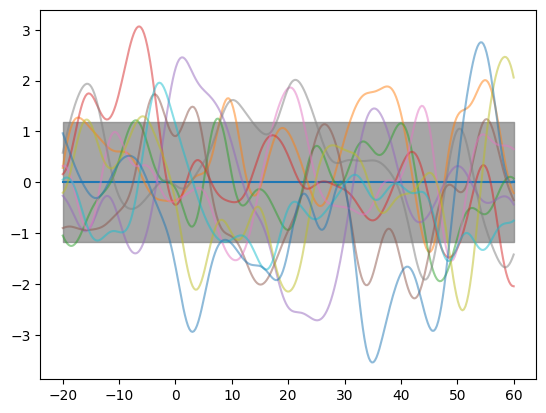

In [61]:
plt.plot(t_test, y_prior, label='prior')
plt.fill_between(t_test.reshape(-1,), y_prior[:,0]-std_prior.reshape(-1,), y_prior[:,0]+std_prior.reshape(-1,), color='gray', alpha=0.7)
plt.plot(t_test, gp.sample_y(t_test, n_samples=10).T, alpha=0.5)

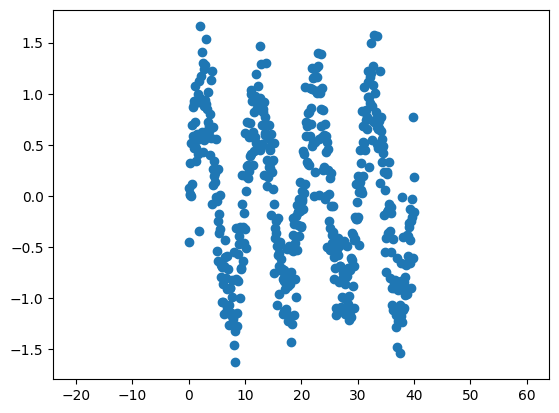

In [67]:
plt.plot(time,  y_noise, 'o', label='data', alpha=1)
plt.plot(t_test, y_prior, label='prior', alpha=0)


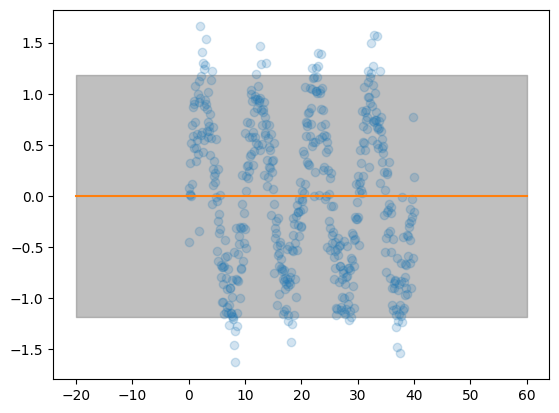

In [62]:
plt.plot(time,  y_noise, 'o', label='data', alpha=0.2)
plt.plot(t_test, y_prior, label='prior')
plt.fill_between(t_test.reshape(-1,), y_prior[:,0]-std_prior.reshape(-1,), y_prior[:,0]+std_prior.reshape(-1,), color='gray', alpha=0.5)

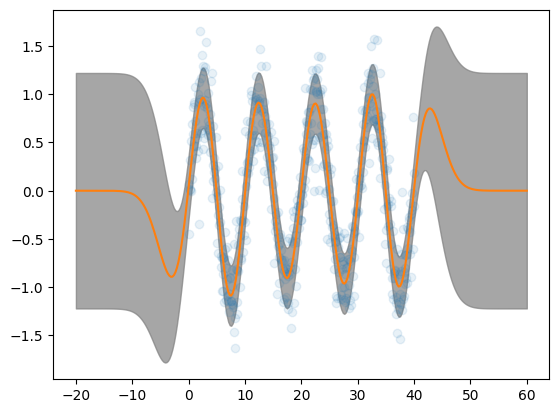

In [68]:
# plt.plot(t_test, y_pred)
plt.plot(time,  y_noise, 'o', label='data', alpha=0.1)
plt.plot(t_test, y_pred, label='GP prediction')
plt.fill_between(t_test.reshape(-1,), y_pred[:,0]-std.reshape(-1,), y_pred[:,0]+ std.reshape(-1,), color='gray', alpha=0.7)

# plt.legend()